# 1. Aspectos gerais do Spark

In [1]:
# Importação de pacotes
import pandas as pd
from pyspark.sql import SparkSession

# Esta parte do código serve para que não dê erro no Jupyter Notebook
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [ ]:
# Conectar ao cluster Spark local
spark = SparkSession.builder \
    .appName("MyApp") \
    .master("local") \
    .getOrCreate()

## 1.1. Leitura dos dados

In [ ]:
# =================================================================================================================
# UTILIZANDO O SPARK PARA LER UM ARQUIVO COM GRANDE VOLUME DE DADOS
# =================================================================================================================

# CONHECENDO NOSSOS DADOS
# fonte: https://www.kaggle.com/datasets/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018?resource=download&select=2017.csv
# Airline Delay and Cancellation Data, 2009 - 2018
# pasta datasets -> dois arquivos -> 1 de aproximadamente 700MB e outro de aproximadamente 476MB

# Carregando o primeiro dataset da base de dados de voos de avioes
df_2017 = spark.read.csv("datasets/voos-avioes/2017.csv", header=True, inferSchema=True)

## 1.2.Visualização dos dados

In [ ]:
# Dando uma olhada nos dados no DataFrame
# Com vertical = False os dados ficam ruim para ler e não é direto a representação como um Pandas Dataframe
df_2017.show(2, vertical = True)

In [ ]:
# Desta forma podemos dar uma olhada nos dados vomo um Dataframe no Pandas
pd.set_option('display.max_columns', None) # mostrar todas as colunas
pd.set_option('display.max_rows', None) # mostrar todas as linhas
df_2017.limit(10).toPandas()

## 1.3. Contagem de linhas

In [ ]:
# Contagem do número de linhas do Dataframe no Spark
row_count = df_2017.count()
print("Number of rows:", row_count)

## 1.4. Filtragem de dados

In [ ]:
# Quando um dataset é lido pelo spark, ele é carregado de forma distribuída na memória
# elas ainda não foram entregues para o driver (Jupyter), essas são as operações de
# de transformações de dados

# Filtrar dados por uma determianda condição
cancelados_2017 = df_2017.filter(df_2017['CANCELLED'] ==1 )  

# As operaçoes de manipulações são feitas distruídas e com execução realizada quando uma ação é chamada
# ação: mostrar os dados

cancelados_2017.limit(10).toPandas()


In [ ]:
# Transformação de dados:
# leitura
# seleção
# agrupamento
# filtros
# ordenação
# joins

# Ações:
# trazer os dados para o Jupyter
# contagem
# salvar
# mostrar os dados

# Podemos fazer a filtragem usando a função where
cancelados_2017 = df_2017.where(df_2017['CANCELLED'] ==1 )
cancelados_2017.limit(10).toPandas()

## 1.5. Operações sobre dados

In [ ]:
# Queremos criar uma variável que sinaliza que o voo esta atrasado quando 
# o tempo de atraso na chegada for maior que 15 minutos

# withColumn é usada para adicionar ou substituir uma coluna em um DataFrame.
# Ela permite criar um novo DataFrame adicionando uma nova coluna com base em uma coluna existente 
#ou em um valor calculado.
from pyspark.sql.functions import isnan, when
import math
df_2017 = df_2017.withColumn('ATRASADO', when(df_2017['ARR_DELAY'] >= 15, 1)
                  .when(df_2017['ARR_DELAY'] < 15, 0)
                  .otherwise(float('nan')))

df_2017.limit(10).toPandas()

In [ ]:
# Façamos agora um exemplo de uma operação de transformação e guardar os dados em uma variável.
# Queremos fazer uma contagem da quantidade de voos atrasados, não atrasados e cancelados, 
# com suas respectivas proporçõs

# A classe Window define uma janela de análise que especifica quais linhas do DataFrame devem 
# ser incluídas em um cálculo de função de janela.
# No código abaixo, a função sum('QUANTIDADE').over(Window.partitionBy()) é usada
# para calcular a soma da coluna 'QUANTIDADE' em todas as linhas do DataFrame, sem particionar
# em grupos. Isso significa que a soma total de 'QUANTIDADE' é calculada para todas as linhas do DataFrame.

from pyspark.sql.functions import col, count, sum
from pyspark.sql.window import Window
group_atrasados_2017 = df_2017 \
    .groupBy('ATRASADO') \
    .agg(count('*').alias('QUANTIDADE')) \
    .withColumn('PORCENTAGEM', col('QUANTIDADE') / sum('QUANTIDADE').over(Window.partitionBy()) * 100)



group_atrasados_2017.toPandas()

## 1.6. Spark para Python

In [ ]:
# O dataframe spark pode ser transferido da memória do python e transformado em um dataframe do python em forma de array com 
# a função collect nessa operação, os dados distribuídos vão todos para o driver na aplicação 
# e faz a transformação
group_atrasados_2017_py =group_atrasados_2017.collect()
group_atrasados_2017_pd = pd.DataFrame(group_atrasados_2017_py, columns = group_atrasados_2017.columns)
group_atrasados_2017_pd

In [ ]:
# Verificando diferença entre quantidade de voos atrasados e voos não atrasados de 2017

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

group_atrasados_2017_pd['ATRASADO'] = group_atrasados_2017_pd['ATRASADO'].astype(str)
xtick_labels = group_atrasados_2017_pd['ATRASADO']
# Create the bar plot
ax.bar(group_atrasados_2017_pd['ATRASADO'], group_atrasados_2017_pd['QUANTIDADE'], color='steelblue', tick_label=xtick_labels)

# Adding labels to the bars
for i in range(len(xtick_labels)):
    plt.text(xtick_labels[i], group_atrasados_2017_pd['QUANTIDADE'][i], str(group_atrasados_2017_pd['QUANTIDADE'][i]), ha='center', va='bottom')


# Set the x and y axis labels
ax.set_xlabel('Voos atrasados')
ax.set_ylabel('Quantidade')

# Set the plot title
ax.set_title('Quantidade de voos atrasados em 2017')

# Remove spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='both', length=0)


# Show the plot
plt.show()

In [ ]:
# Verificando os missing values
df_nan = df_2017.filter(df_2017['ATRASADO'] == float('nan'))
df_nan.limit(10).toPandas()

## 1.7. Python para Spark

In [ ]:
# Levando o dataframe python para o cluster spark
schema =  group_atrasados_2017.columns
group_atrasados_2017_spark = spark.createDataFrame(group_atrasados_2017_py, schema)

group_atrasados_2017_spark.toPandas()

In [ ]:
# Agora vamos fazer as mesmas coisas que fizemos anteriormente para a base de dados de 2018
df_2018 = spark.read.csv("datasets/voos-avioes/2018.csv", header=True, inferSchema=True)

In [ ]:
cancelados_2018 = df_2018.filter(df_2018['CANCELLED'] ==1 )  
df_2018 = df_2018.withColumn('ATRASADO', when(df_2018['ARR_DELAY'] >= 15, 1)
                  .when(df_2018['ARR_DELAY'] < 15, 0)
                  .otherwise(float('nan')))



In [ ]:
group_atradados_2018 = df_2018 \
    .groupBy('ATRASADO') \
    .agg(count('*').alias('QUANTIDADE')) \
    .withColumn('PORCENTAGEM', col('QUANTIDADE') / sum('QUANTIDADE').over(Window.partitionBy()) * 100)


group_atradados_2018.toPandas()

In [ ]:
group_atradados_2018_py =group_atradados_2018.collect()
group_atradados_2018_pd = pd.DataFrame(group_atradados_2018_py, columns = group_atradados_2018.columns)
group_atradados_2018_pd

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

group_atradados_2018_pd['ATRASADO'] = group_atradados_2018_pd['ATRASADO'].astype(str)
xtick_labels = group_atradados_2018_pd['ATRASADO']
# Create the bar plot
ax.bar(group_atradados_2018_pd['ATRASADO'], group_atradados_2018_pd['QUANTIDADE'], color='steelblue', tick_label=xtick_labels)

# Adding labels to the bars
for i in range(len(xtick_labels)):
    plt.text(xtick_labels[i], group_atradados_2018_pd['QUANTIDADE'][i], str(group_atradados_2018_pd['QUANTIDADE'][i]), ha='center', va='bottom')


# Set the x and y axis labels
ax.set_xlabel('Voos atrasados')
ax.set_ylabel('Quantidade')

# Set the plot title
ax.set_title('Quantidade de voos atrasados em 2018')

# Remove spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='both', length=0)


# Show the plot
plt.show()

In [ ]:
# Juntando os dataframes
df_all = df_2017.unionAll(df_2018)
df_all.limit(10).toPandas()

In [ ]:
# Número total de linhas
row_count = df_all.count()
print("Number of rows:", row_count)

In [ ]:
# Estrategia para calcular quantidade de linhas em dataset gigantescos
# criar um objeto de fração com valor bem pequeno (Ex. 1% dos dados)
fracao_contagem = 0.01
# Coleta uma pequena amostra do dataset completo
pequena_amostra = df_all.sample(withReplacement=True, fraction=fracao_contagem, seed=42)
# Contagem de linhas do dataset
row_count = pequena_amostra.count()
print("Number of rows:", row_count)

In [ ]:
# Aproximacao contagem
row_count/fracao_contagem

## 1.8. Parquet

In [ ]:


df_all.write.mode("overwrite").parquet("datasets/voos-avioes.parquet")

In [ ]:


df_all_parquet = spark.read.parquet("datasets/voos-avioes.parquet")
df_all_parquet.limit(10).toPandas()

In [ ]:
# Número total de linhas
row_count = df_all_parquet.count()
print("Number of rows:", row_count)

In [ ]:
from pyspark.sql.functions import year, col

df_all_parquet = df_all_parquet.withColumn("ANO", year(col("FL_DATE")).cast("string"))

df_all_parquet.limit(10).toPandas()


In [ ]:

df_all_parquet.write.partitionBy("ANO").parquet("datasets/voos-avioes-ano.parquet", mode="overwrite")



In [ ]:
from pyspark.sql.functions import month

df_all_parquet = df_all_parquet.withColumn("MES", month("FL_DATE").cast("string"))

In [ ]:

df_all_parquet.write.partitionBy(["ANO", "MES"]).parquet("datasets/voos-avioes-ano-mes.parquet", mode="overwrite")



# 2. Regressão Linear

## 2.1. Selecionar dados

In [ ]:
# Modelos de regressao linear

# Objetivo 1: 
# Desenvolver um modelo para calcular tempo decorrido real em relacao a distancia percorrida
# o mais simples possivel

# Selecionando apenas as colunas que sao importantes para o modelo
dados_selecionados = df_all.select("ACTUAL_ELAPSED_TIME", "DISTANCE")

# Retirar missing values do dataset caso existam
dados_selecionados = dados_selecionados.na.drop()


## 2.2. Análise de correlação

In [ ]:
# Análise de correlação

# O VectorAssembler é uma classe no PySpark usada para transformar um conjunto de colunas em uma
# única coluna vetorizada. Ele é frequentemente usado para preparar dados antes de alimentá-los em 
# algoritmos de aprendizado de máquina que esperam vetores de recursos como entrada.
# A função principal do VectorAssembler é combinar várias colunas em um único vetor, onde cada coluna
# é tratada como uma dimensão do vetor resultante. Ele cria uma nova coluna que contém o vetor resultante.
# Isso é útil quando você tem várias colunas de recursos independentes e deseja concatená-las em um único 
# vetor para usar em algoritmos de machine learning.

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Selecionar as colunas para a análise de correlação
selected_columns = ["ACTUAL_ELAPSED_TIME", "DISTANCE"]

# Criar Vector Assembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
data = assembler.transform(dados_selecionados).select("features")

# Calcular a matriz de correlação
corr_matrix = Correlation.corr(data, "features", method="pearson").head()

# Extract the correlation matrix as a 2D array
corr_array = corr_matrix[0].toArray()

In [ ]:
corr_array

## 2.3. Visualização dos dados

In [ ]:
# Criar um objeto de fração com valor bem pequeno (Ex. 1% dos dados)
fracao_contagem = 0.01
# Coleta uma pequena amostra do dataset completo
pequena_amostra = dados_selecionados.sample(withReplacement=True, fraction=fracao_contagem, seed=42)
pequena_amostra_pd = pequena_amostra.toPandas()
import matplotlib.pyplot as plt
import seaborn as sns

# Verificando a correlacao das duas variaveis no grafico de dispersao
sns.set_style("whitegrid")
sns.scatterplot(x="DISTANCE", y="ACTUAL_ELAPSED_TIME", data=pequena_amostra_pd, alpha=0.1)
sns.regplot(x="DISTANCE", y="ACTUAL_ELAPSED_TIME", data=pequena_amostra_pd, color="red", scatter=False)

plt.xlabel("Distancia percorrida")
plt.ylabel("Tempo total decorrido")

plt.show()

## 2.4. Modelo

In [ ]:
# Realizando o fit do modelo
from pyspark.ml.regression import GeneralizedLinearRegression

# Criar Vector Assembler
assembler = VectorAssembler(inputCols=["DISTANCE"], outputCol="features")
data = assembler.transform(dados_selecionados)

# Definindo o modelo 
model = GeneralizedLinearRegression(labelCol="ACTUAL_ELAPSED_TIME", featuresCol="features")

# Fit do modelo
modelo_linear = model.fit(data)

In [ ]:
summary = modelo_linear.summary
summary

In [ ]:
# Print the coefficients and other model statistics
print("Intercept: " + str(modelo_linear.intercept))
print("Coefficients: " + str(modelo_linear.coefficients))
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()

In [ ]:
# Usando o a funcao LinearRegression conseguimos tirar o r2

from pyspark.ml.regression import LinearRegression

# Criar Vector Assembler
assembler = VectorAssembler(inputCols=["DISTANCE"], outputCol="features")
data = assembler.transform(dados_selecionados)

# Definindo o modelo
model_ = LinearRegression(labelCol="ACTUAL_ELAPSED_TIME", featuresCol="features")

# Fit do modelo
modelo_linear_ = model_.fit(data)

In [ ]:
summary_ = modelo_linear_.summary
summary_ # Esta função não possui aquela tabela bonita.

In [ ]:
summary_.r2

## 2.5. Predições

### Dados existentes

In [ ]:
# Fazendo predições usando o último modelo

predictions = summary.predictions
# Ou também
# predictions = modelo_linear.transform(data)
predictions.show()

### Dados novos

In [ ]:
# Realizando um predict no modelo distribuído no spark

# Criando um dataframe no pandas
dados_novos = pd.DataFrame({'DISTANCE': [2000]})

# Transformando o dataframe em pandas em um dataframe Spark
dados_novos_spark = spark.createDataFrame(dados_novos)

# Exibir o DataFrame
dados_novos_spark.show()

In [ ]:
# Selecionar as colunas para a predição
selected_columns = ["DISTANCE"]

# Criando Vector Assembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
dados_novos_spark_features = assembler.transform(dados_novos_spark).select("features")

# Qual o tempo total de viagem quando a distância é igual a 2000 km?
resultado = modelo_linear.transform(dados_novos_spark_features)
resultado.show()

In [ ]:
# Análise de correlação

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Selecionar as colunas para a análise de correlação
selected_columns = ["ACTUAL_ELAPSED_TIME", "prediction"]

# Criando Vector Assembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features_corr")
data = assembler.transform(predictions).select("features_corr")

# Calculando a matriz de correlação
corr_matrix = Correlation.corr(data, "features_corr", method="pearson").head()

# Extraindo a matriz de correlação como um array 2d
corr_array = corr_matrix[0].toArray()

In [ ]:
corr_array**2 # Os elementos fora da diagonal tem que ser iguais a R^2

## 2.6. Análise dos resíduos

In [ ]:
# Coletando os resíduos
residuos = summary.residuals()

# Pequena amostra para verificar a distribuição dos resíduos
fracao_contagem = 0.01
amostra_residuos = residuos.sample(withReplacement=True, fraction=fracao_contagem, seed=42)
amostra_residuos_pd = amostra_residuos.toPandas()

In [ ]:
amostra_residuos.limit(10).show()

In [ ]:

import matplotlib.pyplot as plt

# Plot do histograma dos resíduos
plt.hist(amostra_residuos_pd["devianceResiduals"], density=True, bins=range(-100, 101, 5), edgecolor='black', alpha = 0.7)
plt.xlabel("Residuos")
plt.ylabel("Frequencia")
plt.title("Histograma dos Residuos")
plt.grid(True)
#plt.show()

# Plot da densidade dos resíduos
#plt.figure()
sns.kdeplot(amostra_residuos_pd["devianceResiduals"], shade=True, lw = 2, color = 'black')
#plt.xlabel("Residuos")
#plt.ylabel("Densidade")
#plt.title("Densidade dos Residuos")
#plt.grid(True)
plt.show()

# 3. Regressão Logística

In [ ]:
# Objetivo 2: 
# Desenvolver um modelo para calcular se o voo vai atrasar para chegar ou não baseado 
# nas variáveis do banco de dados
# variável dependente: ATRASADO
# Proposta de modelo: Regressão Logística




# Revisitando nosso dataset completo
df_all.limit(10).toPandas()

In [ ]:
# Adicionando variáveis de tempo para verificar as interferências dessas variáveis nos atrasos dos voos
from pyspark.sql.functions import col, month, dayofweek
# Criar as colunas ATRASO_PARTIDA e ATRASO_CHEGADA convertendo DEP_DELAY e ARR_DELAY para numérico
df_all_tratado = df_all.withColumn('ATRASO_PARTIDA', col('DEP_DELAY').cast('float'))
df_all_tratado = df_all_tratado.withColumn('ATRASO_CHEGADA', col('ARR_DELAY').cast('float'))

# Criar a coluna MES com o mês da data
df_all_tratado = df_all_tratado.withColumn('MES', month('FL_DATE').cast('string'))

# Criar a coluna DIA_DA_SEMANA com o dia da semana da data
df_all_tratado = df_all_tratado.withColumn('DIA_DA_SEMANA', dayofweek('FL_DATE').cast('string'))

# Exibir o DataFrame tratado
df_all_tratado.limit(10).toPandas()

## 3.1. Visualização dos dados

In [ ]:
# Coletando uma pequena amostra para verificar essas variáveis graficamente
# Agrupar os dados por DIA_DA_SEMANA e calcular a média de ATRASO_CHEGADA
from pyspark.sql.functions import col, mean

grouped_all_tratado = df_all_tratado \
    .groupBy('DIA_DA_SEMANA') \
    .agg(mean(col('ATRASO_CHEGADA')).alias('media_atraso_chegada'))


grouped_all_tratado_py = grouped_all_tratado.collect()

In [ ]:
grouped_all_tratado_pd = pd.DataFrame(grouped_all_tratado_py, columns = grouped_all_tratado.columns)
grouped_all_tratado_pd

In [ ]:
import matplotlib.pyplot as plt

# Extrair os dados do DataFrame
x = grouped_all_tratado_pd['DIA_DA_SEMANA'].astype(str)
y = grouped_all_tratado_pd['media_atraso_chegada'].round(2)

# Criar o gráfico de barras
plt.bar(x, y, color='steelblue')

# Configurar os rótulos dos eixos e o título do gráfico
plt.xlabel('Dia da semana')
plt.ylabel('Média de atraso dos voos')
plt.title('Média de atraso dos voos por dia da semana')

# Exibir o gráfico
plt.show()


In [ ]:
# Coletando uma pequena amostra para verificar essas variacoes graficamente agora nos meses
# Coletando uma pequena amostra para verificar essas variáveis graficamente
# Agrupar os dados por DIA_DA_SEMANA e calcular a média de ATRASO_CHEGADA
from pyspark.sql.functions import col, mean

grouped_all_tratado_ = df_all_tratado \
    .groupBy('MES') \
    .agg(mean(col('ATRASO_CHEGADA')).alias('media_atraso_chegada'))


grouped_all_tratado_py_ = grouped_all_tratado_.collect()

In [ ]:
grouped_all_tratado_pd_ = pd.DataFrame(grouped_all_tratado_py_, columns = grouped_all_tratado_.columns)
grouped_all_tratado_pd_

In [ ]:
import matplotlib.pyplot as plt

# Extrair os dados do DataFrame
x = grouped_all_tratado_pd_['MES'].astype(str)
y = grouped_all_tratado_pd_['media_atraso_chegada'].round(2)

# Criar o gráfico de barras
plt.bar(x, y, color='steelblue')

# Configurar os rótulos dos eixos e o título do gráfico
plt.xlabel('Dia da semana')
plt.ylabel('Média de atraso dos voos')
plt.title('Media de atraso dos voos por mes')

# Exibir o gráfico
plt.show()


## 3.2. Selecionar dados

In [ ]:
# Selecionando as variáveis da modelagem
dados_selecionados = df_all_tratado.select( "ATRASADO", "CRS_DEP_TIME", "MES", "DIA_DA_SEMANA", "DISTANCE")

# Verificando minhas variáveis de entrada do modelo
dados_selecionados.limit(10).toPandas()

In [ ]:
# A função Bucketizer no PySpark é usada para converter uma coluna numérica contínua em uma coluna com 
# valores discretos (buckets) com base em intervalos específicos. É útil para criar recursos categóricos 
# a partir de dados numéricos contínuos.

# A função Bucketizer requer a definição dos pontos de corte (splits) que serão usados para dividir os 
# valores contínuos em intervalos discretos. Por exemplo, se definirmos os splits como [0, 10, 20, 30],
# a função irá dividir os valores em quatro intervalos: valores menores que 0, valores entre 0 e 10, 
# valores entre 10 e 20, e valores entre 20 e 30.

from pyspark.ml.feature import Bucketizer

# Definir os limites dos intervalos
splits = [float(x) for x in range(0, 2401, 400)]

# Criar o Bucketizer
bucketizer = Bucketizer(inputCol="CRS_DEP_TIME", outputCol="HORAS", splits=splits)

# Aplicar o Bucketizer aos dados
dados_selecionados = bucketizer.transform(dados_selecionados)

# Exibir o resultado
dados_selecionados.limit(10).toPandas()

In [ ]:
# Retirar missing values do dataset caso existam
dados_selecionados = dados_selecionados.na.drop()
dados_selecionados.printSchema()

## 3.3. Dummyzação

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

# A função StringIndexer no PySpark é usada para converter uma coluna de strings em uma coluna de índices 
# numéricos. Ela atribui um índice único para cada valor distinto na coluna de entrada, em ordem de frequência 
# de ocorrência. Isso pode ser útil para preparar dados de texto ou dados categóricos para algoritmos de 
# aprendizado de máquina que exigem entradas numéricas.


# A classe Pipeline no PySpark é uma ferramenta para facilitar o fluxo de trabalho de construção e implantação 
# de pipelines de transformação e modelagem de dados. O pipeline permite que você organize e encadeie várias 
# etapas de processamento de dados de maneira sequencial.

# Um pipeline consiste em uma sequência ordenada de etapas, onde cada etapa é uma transformação de dados ou um
# estimador de modelo. As transformações de dados são responsáveis por pré-processar os dados, enquanto os estimadores
# são usados para ajustar modelos aos dados. Cada etapa do pipeline é especificada como uma tupla contendo um nome 
# para a etapa e um objeto transformador ou estimador.
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", stringOrderType="alphabetAsc") for col in ["DIA_DA_SEMANA", "MES"]]
indexer_pipeline = Pipeline(stages=indexers)
indexers_model = indexer_pipeline.fit(dados_selecionados)

df_indexed = indexers_model.transform(dados_selecionados)

df_indexed.limit(10).toPandas()

In [ ]:

# A função OneHotEncoder no PySpark é uma transformação que converte variáveis categóricas em representações 
# numéricas binárias. Ela mapeia cada valor distinto de uma variável categórica em um vetor binário, onde cada
# posição do vetor representa uma categoria possível e é preenchida com 1 ou 0, indicando a presença ou ausência 
# da categoria.

# É efetivamente a dummyzação.

dummy_cols = ["DIA_DA_SEMANA_index", "MES_index"]
encoder = OneHotEncoder(inputCols=dummy_cols, outputCols=[col+"_encoded" for col in dummy_cols])
encoder_pipeline = Pipeline(stages=[encoder])
encoder_model = encoder_pipeline.fit(df_indexed)
df_encoded = encoder_model.transform(df_indexed)

df_encoded.limit(10).toPandas()

## 3.4. Modelo

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Criar Vector Assembler
assembler = VectorAssembler(inputCols=["DIA_DA_SEMANA_index_encoded", "HORAS", "MES_index_encoded", "DISTANCE"], outputCol="features")
data = assembler.transform(df_encoded)

# Criar o modelo de regressão logística
model = LogisticRegression(labelCol="ATRASADO", featuresCol="features", family="binomial")

# Treinar o modelo
modelo_logistico = model.fit(data)


In [ ]:
summary = modelo_logistico.summary
summary

In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression

# Criar Vector Assembler
assembler = VectorAssembler(inputCols=["DIA_DA_SEMANA_index_encoded", "HORAS", "MES_index_encoded", "DISTANCE"], outputCol="features")
data = assembler.transform(df_encoded)

# Modelo
model = GeneralizedLinearRegression(family="binomial", link="logit", labelCol="ATRASADO")
modelo_logistico = model.fit(data)

In [ ]:
summary = modelo_logistico.summary
summary

## 3.5. Matriz de confusão

### Dados existentes

In [ ]:
# Fazer as previsões usando o modelo
predictions = modelo_logistico.transform(data)

predictions.limit(10).toPandas()


### Dados novos

In [ ]:
# Realizando um predict no modelo distribuído no spark

# Criando um dataframe no pandas
dados_novos = pd.DataFrame({'DIA_DA_SEMANA': [1,2,3,4,5,6,7,1,2,3,4, 5], "HORAS": [2,2,2,2,2,2,2,2,2,2,2,2], "MES": [1,2,3,4,5,6,7,8,9,10,11, 12], "DISTANCE": [2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000]})

# Transformando o dataframe em pandas em um dataframe Spark
dados_novos_spark = spark.createDataFrame(dados_novos)

# Registrar o DataFrame como uma tabela temporária
#dados_novos_spark.createOrReplaceTempView("dados_novos_spark")

# Exibir o DataFrame
dados_novos_spark.show()

In [ ]:
dados_novos_indexed = indexers_model.transform(dados_novos_spark)
dados_novos_indexed.show()

In [ ]:
dados_novos_encoded = encoder_model.transform(dados_novos_indexed)
dados_novos_encoded.toPandas()

In [ ]:
# Selecionar as colunas para a predição
selected_columns = ["DIA_DA_SEMANA_index_encoded", "HORAS", "MES_index_encoded", "DISTANCE"]

# Assemble the selected columns into a feature vector
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
dados_novos_encoded_features = assembler.transform(dados_novos_encoded).select("features")



# Qual o tempo total de viagem quando a distância é igual a 2000 km?
resultado = logistic_model.transform(dados_novos_encoded_features)
resultado.toPandas()

## 3.6. Matriz de confusão

In [ ]:
from pyspark.sql.functions import when

# Adicionar a coluna "y_hat" ao DataFrame com base no threshold de 0.5
predictions = predictions.withColumn("y_hat", when(predictions["prediction"] >= 0.5, 1).otherwise(0))

# Exibir os resultados
predictions.limit(5).toPandas()

In [ ]:
from pyspark.sql.functions import col

# Converter as colunas para tipo String
predictions = predictions.withColumn("ATRASADO", col("ATRASADO").cast("string"))
predictions = predictions.withColumn("y_hat", col("y_hat").cast("string"))

# Calcular a matriz de confusão
confusion_matrix = predictions.groupBy("ATRASADO").pivot("y_hat").count().na.fill(0)

# Exibir a matriz de confusão
confusion_matrix.show()

## 3.7. Área curva ROC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = predictions.withColumn("ATRASADO", col("ATRASADO").cast("float"))

# Criar o avaliador BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="ATRASADO", rawPredictionCol="prediction", metricName="areaUnderROC")

# Calcular a métrica AUC
auc = evaluator.evaluate(predictions)

# Exibir o valor da métrica AUC
print("AUC:", auc)


In [ ]:
spark.stop()

# 4. Deployment de dados com MLflow

In [2]:
estudante_escola = pd.read_csv("/datasets/estudante_escola.csv", delimiter=',')
estudante_escola

,estudante,escola,desempenho,horas,texp
0,1,1,25.0,11,3.6
1,2,1,52.0,23,3.6
2,3,1,52.0,25,3.6
3,4,1,30.0,14,3.6
4,5,1,51.0,24,3.6
...,...,...,...,...,...
353,354,10,46.5,28,3.9
354,355,10,21.0,9,3.9
355,356,10,42.0,27,3.9
356,357,10,14.0,7,3.9


In [3]:
#Características das variáveis do dataset
estudante_escola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   estudante   358 non-null    int64  
 1   escola      358 non-null    int64  
 2   desempenho  358 non-null    float64
 3   horas       358 non-null    int64  
 4   texp        358 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 14.1 KB


In [4]:
# Ajustando os tipos das variáveis categóricas
estudante_escola['estudante'] = estudante_escola['estudante'].astype('category')
estudante_escola['escola'] = estudante_escola['escola'].astype('category')
estudante_escola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   estudante   358 non-null    category
 1   escola      358 non-null    category
 2   desempenho  358 non-null    float64 
 3   horas       358 non-null    int64   
 4   texp        358 non-null    float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 20.8 KB


In [5]:
# Matriz de correlações

corr = estudante_escola[['horas','desempenho', 'texp']].corr()
corr


,horas,desempenho,texp
horas,1.000000,0.307386,-0.245678
desempenho,0.307386,1.000000,0.752033
texp,-0.245678,0.752033,1.000000


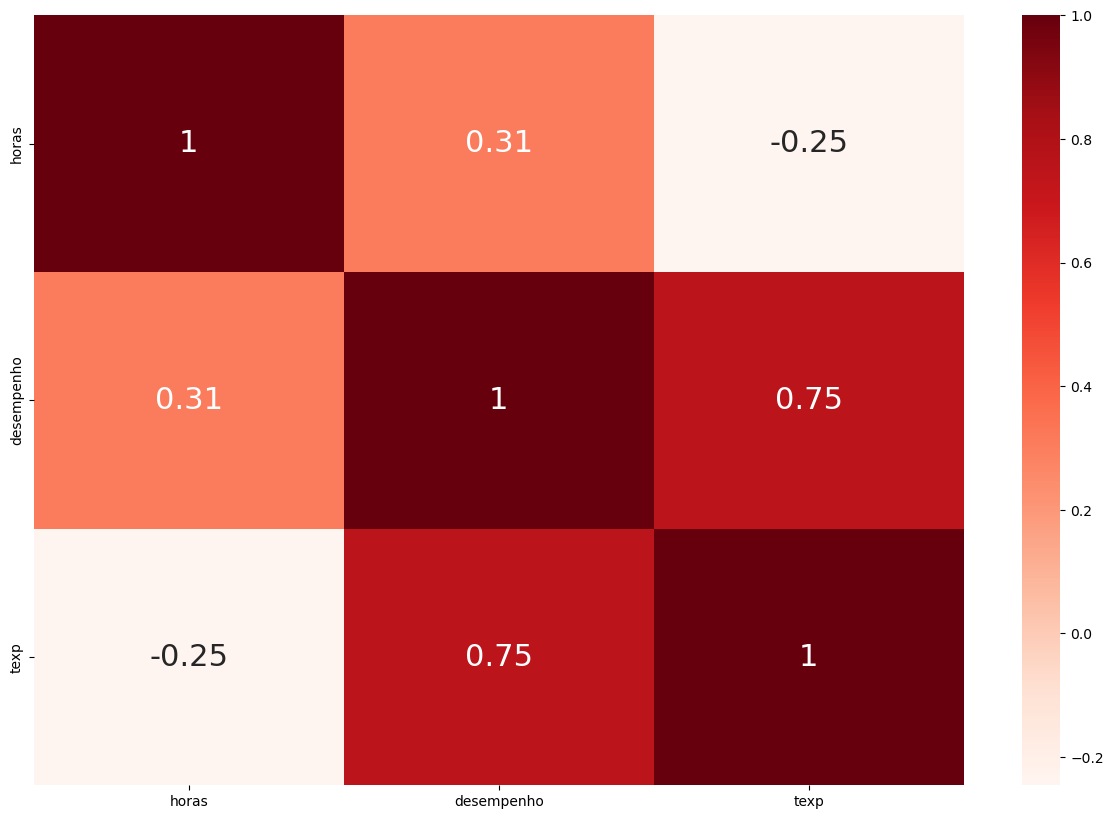

In [6]:
import matplotlib.pyplot as plt # biblioteca de visualização de dados
import seaborn as sns # biblioteca de visualização de informações estatísticas

# Heatmap das correlações
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap = plt.cm.Reds,
            annot_kws={'size':22})
plt.show()

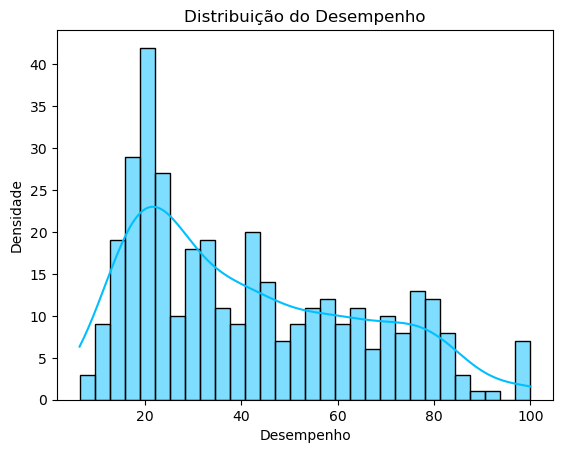

In [7]:
sns.histplot(data=estudante_escola, x='desempenho', kde=True, color='deepskyblue', bins = 30)
plt.xlabel('Desempenho')
plt.ylabel('Densidade')
plt.title('Distribuição do Desempenho')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


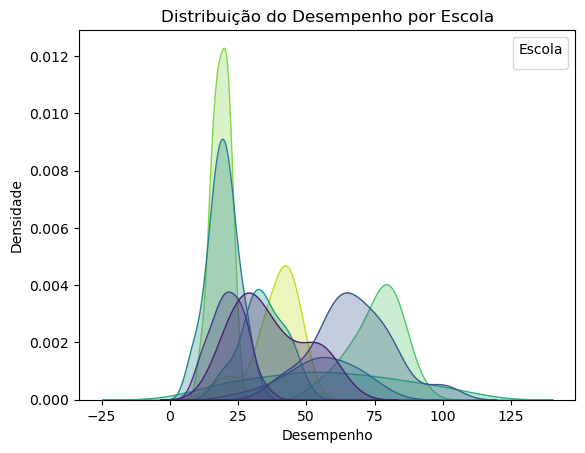

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=estudante_escola, x='desempenho', hue='escola', fill=True, alpha=0.3, palette='viridis')
plt.xlabel('Desempenho')
plt.ylabel('Densidade')
plt.title('Distribuição do Desempenho por Escola')
plt.legend(title='Escola')
plt.show()

In [9]:
# Localizando valores ausentes no dataframe
estudante_escola.isnull().any()


estudante     False
escola        False
desempenho    False
horas         False
texp          False
dtype: bool

In [10]:
# Contando a quantidade de valores ausentes em cada variável
estudante_escola.isnull().sum()

estudante     0
escola        0
desempenho    0
horas         0
texp          0
dtype: int64

In [17]:
import mlflow

# por algum motivo não consigo acessar o mlflow ui

